####  Solução numérica 

Para U < 0 :

\begin{equation}
C_{j+1}^{n+1}*(\alpha - \beta) + C_{j}^{n+1}* (1- \alpha +2*\beta) + C_{j-1}^{n+1} *(-\beta) = C_{j}^{n} 
\end{equation}

Para U > 0 :

\begin{equation}
C_{j+1}^{n+1}*(- \beta) + C_{j}^{n+1}* (1 + \alpha +2*\beta) + C_{j-1}^{n+1} *(-\alpha -\beta) = C_{j}^{n} 
\end{equation}

Com as seguintes condições iniciais e de contorno:

\begin{equation}
    C(x,t=0) = C_{0}
\end{equation}

Condição de contorno:

\begin{equation}
c(0, t)=\left\{\begin{array}{lc}c_{0} & 0 < t < t_{0} \\
0 & t>t_{o}\end{array}\right.
\end{equation}

\begin{equation}
\frac{\partial c}{\partial x}(\infty, t)=0
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.sparse as sp
import scipy.sparse.linalg 
import scipy.linalg as la
from numpy import zeros
import pandas as pd

In [18]:
#===============================================================
# Defining parameters
#===============================================================

tmin = 0.
tmax = 780.0 # Tempo total de análise - 24 hrs = 1440 min
dt = 10.0 # Passo no tempo dt = 10min
nt = int(tmax/dt) # Número de iterações no tempo
t = np.arange(tmin, tmax, dt) # vetor tempo para plotar

xmin = 0.
xmax = 100900.0 # Distância total percorrida
dx = 0.5 # Passo no espaço
nx = int(xmax/dx) # Número de pontos em x, considera x=0 e x=xmax
x = np.arange(xmin, xmax, dx)

H = 4.0 # m
# c = 0.5 # Celeridade do fluxo - valor máximo em x = 1.53 m/s
# u_estrela = 0.1 * c 
# D = u_estrela * H # Difusão = u* * H

#===============================================================
# Stability check
#===============================================================

courant = 1.6*dt/dx                 # Número de Courant <= 1
if courant <= 1:
  print('Courant: OK')
else:
  print('Courant: Corrigir')

pe = 1.6 * dx /(0.1*1.6*H)                    # Núemro de pèclet <= 2
if pe <= 2:
  print('Pèclet: OK')
else:
  print('Pèclet: Corrigir')

neumann = (0.1*1.6*H) *dt/dx**2             # Von Neumann <= 1/2
if neumann <= 0.5:
  print('Neumann: OK')
else:
  print('Neumann: Corrigir')



Courant: Corrigir
Pèclet: OK
Neumann: Corrigir


In [3]:
# #===============================================================
# # Definir matriz tridiagonal de solução (A)
# #===============================================================

# # Diagonais inferior, central e superior (k1,k2,k3)

# alfa  = c*dt/dx                                             # Stability condition - Udt/dx
# beta  = D*dt/(dx**2)                                        # Stability condition - Ddt/dx^2

# k1    =     - beta                                          # Diagonal inferior 
# k2    = 1 - alfa + 2*beta                                   # Diagonal meio
# k3    =     alfa - beta                                     # Diagonal superior

# # A = (np.eye(nx, k=-1)*k1 + np.eye(nx)*k2 + np.eye(nx, k=1)*k3) # Matriz de solução (A)
# A = (sp.eye(nx, k=-1)*k1 + sp.eye(nx)*k2 + sp.eye(nx, k=1)*k3) # Matriz de solução (A)
# A = sp.csr_matrix(A)
# A[0,0] = 1
# A[0,1] = 0
# A[nx-1,nx-1] = 1
# A[nx-1,nx-2] = 0

#===============================================================
# Definir vertor resposta (b)
#===============================================================

b = np.zeros(nx)

# Aplicar condição inicial 

ci = 0 # c(x.t=0) = 0

def CI(x):                                                 # define a condição inicial
    if xmin <= x <= xmax:
        return ci          

for i in range(nx):                                         # monta a condição inicial
   xi = i*dx
   b[i] = CI(xi)

# Aplicar as condições de contorno 

b[0] = 35.0 # c(x=1, t) = 35
b[nx-1] =  0 # c(x=xmax, t) = 0 

In [9]:
df = pd.read_excel('https://github.com/CostaNathan/doctorate/blob/8cb17733fd8f2466c8fe780a1b04c1497652b92e/Trabalho_3/Arquivos_base/dominio_1_corrigido.xlsx?raw=true', header=1 ,sheet_name= 'interpolado_10')
df.drop(labels = [df.columns[7],df.columns[8],df.columns[9]], axis = 1, inplace=True)

# organizar os dataframes para cada hora a se interpolar

df_h1 = df.iloc[:,0:9]
df_h1= df_h1.drop(['0_elev', '1_elev'], axis = 1) # primeira hora para interpolar

df_h2 = df.iloc[:,0:11]
dummy = df_h2['1_vel']
df_h2= df_h2.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev'], axis = 1) 
df_h2.insert(1,'1_vel', dummy)

df_h3 = df.iloc[:,0:13]
dummy = df_h3['2_vel']
df_h3= df_h3.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev'], axis = 1) 
df_h3.insert(1,'2_vel', dummy)

df_h4 = df.iloc[:,0:15]
dummy = df_h4['3_vel']
df_h4= df_h4.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev'], axis = 1) 
df_h4.insert(1,'3_vel', dummy)

df_h5 = df.iloc[:,0:17]
dummy = df_h5['4_vel']
df_h5= df_h5.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev'], axis = 1) 
df_h5.insert(1,'4_vel', dummy)

df_h6 = df.iloc[:,0:19]
dummy = df_h6['5_vel']
df_h6= df_h6.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev'], axis = 1) 
df_h6.insert(1,'5_vel', dummy)

df_h7 = df.iloc[:,0:21]
dummy = df_h7['6_vel']
df_h7= df_h7.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev'], axis = 1) 
df_h7.insert(1,'6_vel', dummy)

df_h8 = df.iloc[:,0:23]
dummy = df_h8['7_vel']
df_h8= df_h8.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev', '7_vel', '8_elev'], axis = 1) 
df_h8.insert(1,'7_vel', dummy)

df_h9 = df.iloc[:,0:25]
dummy = df_h9['8_vel']
df_h9= df_h9.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev', '7_vel', '8_elev', '8_vel', '9_elev'], axis = 1) 
df_h9.insert(1,'8_vel', dummy)

df_h10 = df.iloc[:,0:27]
dummy = df_h10['9_vel']
df_h10= df_h10.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev', '7_vel', '8_elev', '8_vel', '9_elev', '9_vel', '10_elev'], axis = 1) 
df_h10.insert(1,'9_vel', dummy)

df_h11 = df.iloc[:,0:29]
dummy = df_h11['10_vel']
df_h11= df_h11.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev', '7_vel', '8_elev', '8_vel', '9_elev', '9_vel', '10_elev', '10_vel', '11_elev'], axis = 1) 
df_h11.insert(1,'10_vel', dummy)

df_h12 = df.iloc[:,0:31]
dummy = df_h12['11_vel']
df_h12= df_h12.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev', '7_vel', '8_elev', '8_vel', '9_elev', '9_vel', '10_elev', '10_vel', '11_elev', '11_vel', '12_elev'], axis = 1) 
df_h12.insert(1,'11_vel', dummy)

df_h13 = df.iloc[:,0:33]
dummy = df_h13['12_vel']
df_h13= df_h13.drop(['0_elev','0_vel', '1_elev','1_vel','2_elev','2_vel','3_elev','3_vel','4_elev','4_vel','5_elev','5_vel','6_elev','6_vel', '7_elev', '7_vel', '8_elev', '8_vel', '9_elev', '9_vel', '10_elev', '10_vel', '11_elev', '11_vel', '12_elev', '12_vel', '13_elev'], axis = 1) 
df_h13.insert(1,'12_vel', dummy)

interpolacao = pd.DataFrame(df_h1).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
df = interpolacao
interpolacao = pd.DataFrame(df_h2).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.1', '2.1', '3.1', '4.1', '5.1', '2_vel']
df = df.join(interpolacao)
interpolacao = pd.DataFrame(df_h3).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.2', '2.2', '3.2', '4.2', '5.2', '3_vel']
df = df.join(interpolacao)
interpolacao = pd.DataFrame(df_h4).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.3', '2.3', '3.3', '4.3', '5.3', '4_vel']
df = df.join(interpolacao)
interpolacao = pd.DataFrame(df_h5).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.4', '2.4', '3.4', '4.4', '5.4', '5_vel']
df = df.join(interpolacao)
interpolacao = pd.DataFrame(df_h6).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.5', '2.5', '3.5', '4.5', '5.5', '6_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h7).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.6', '2.6', '3.6', '4.6', '5.6', '7_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h8).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.7', '2.7', '3.7', '4.7', '5.7', '8_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h9).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.8', '2.8', '3.8', '4.8', '5.8', '9_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h10).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.9', '2.9', '3.9', '4.9', '5.9', '10_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h11).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.10', '2.10', '3.10', '4.10', '5.10', '11_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h12).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.11', '2.11', '3.11', '4.11', '5.11', '12_vel']
df = df.join(interpolacao) 
interpolacao = pd.DataFrame(df_h13).interpolate()
interpolacao = interpolacao.interpolate(axis=1)
interpolacao.drop(labels= [interpolacao.columns[0]], axis=1, inplace=True)
interpolacao.columns = ['1.12', '2.12', '3.12', '4.12', '5.12', '13_vel']
df = df.join(interpolacao) 


In [21]:
#===============================================================
# # Definir matriz tridiagonal de solução (A)
#===============================================================

u_estrela = np.zeros(nx)
D = np.zeros(nx)

alfa = np.zeros(nx)
beta = np.zeros(nx)

k1 = np.zeros(nx)
k2 = np.zeros(nx)
k3 = np.zeros(nx)

A = (sp.eye(nx, k=-1) + sp.eye(nx) + sp.eye(nx, k=1)) # Matriz de solução (A)
A = sp.csr_matrix(A)
# A[0,0] = 1
# A[0,1] = 0
# A[nx-1,nx-1] = 1
# A[nx-1,nx-2] = 0
    

#===============================================================
# Iterações no tempo e no espaço
#===============================================================

temp_resposta = np.zeros(nt)
for i in range(nt):
    if i%5 == 0:
        temp_resposta[i] = i

dummy_answer = zeros([nt, nx])
cont = 0

rows,cols = A.nonzero()
for n in range(0, nt):
    for i in range(0, nx):
       
        u_estrela[i] = 0.1 *  df.iloc[i,n] 
        D[i] = u_estrela[i] * H  
        alfa[i]  =  df.iloc[i,n]*dt/dx                           # Stability condition - Udt/dx
        beta[i]  = D[i]*dt/(dx**2)                               # Stability condition - Ddt/dx^2

        k1[i]    =     - beta[i]                                        # Diagonal inferior 
        k2[i]    = 1 - alfa[i] + 2*beta[i]                                 # Diagonal meio
        k3[i]    =     alfa[i] - beta[i]                            # Diagonal superior
 
    for row, col in zip(rows, cols):
        if row == col:
            A[row, col] = k2[i]
        if row > col:
            A[row,col] = k1[i]
        if row < col:
            A[row,col] = k3[i]
    
    A[0,0] = 1
    A[0,1] = 0
    A[nx-1,nx-1] = 1
    A[nx-1,nx-2] = 0
            

    u = sp.linalg.spsolve(A, b)

    if cont == temp_resposta[n]:
        dummy_answer[n,:] = u
    b = u    
    cont +=1

KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp/ipykernel_2632/3225480771.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7, 5), dpi=50)


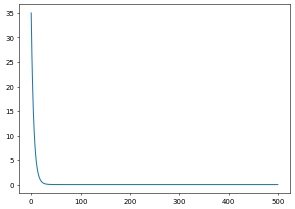

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

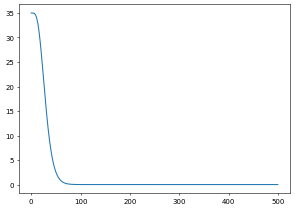

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

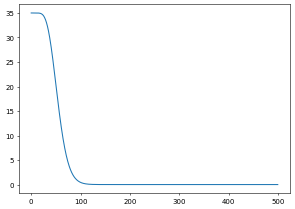

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

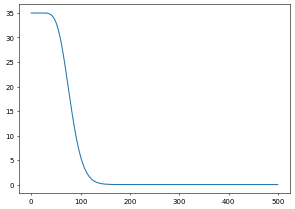

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

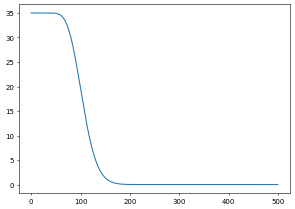

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

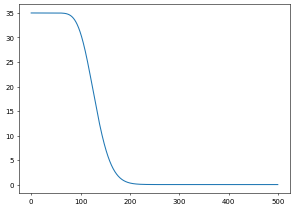

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

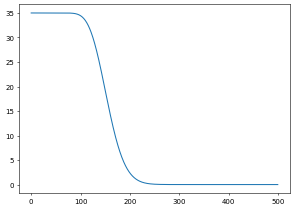

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

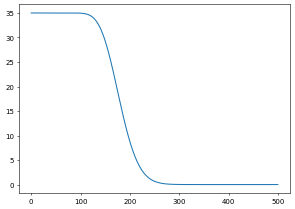

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

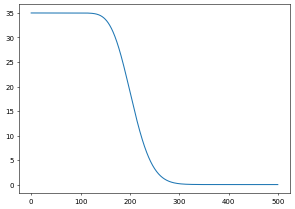

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

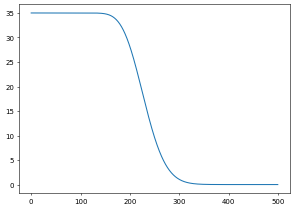

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

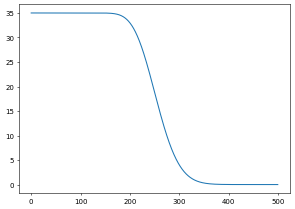

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

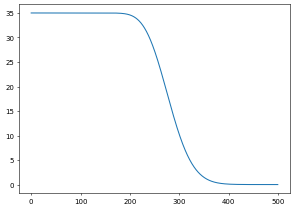

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

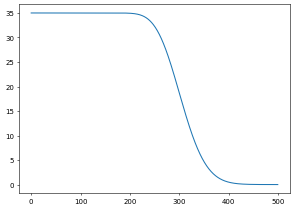

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

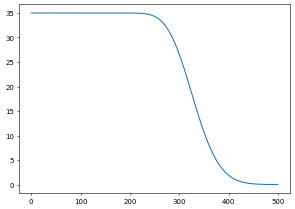

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

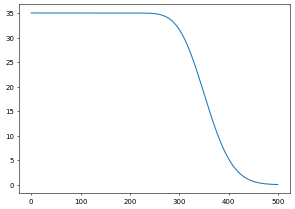

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

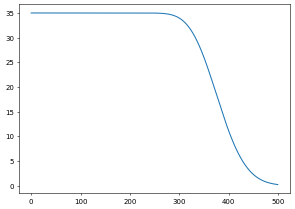

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

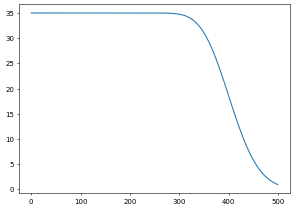

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

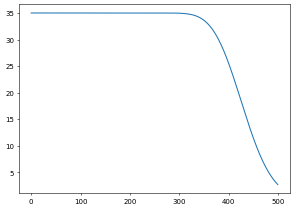

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

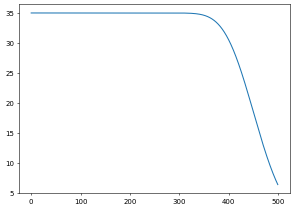

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

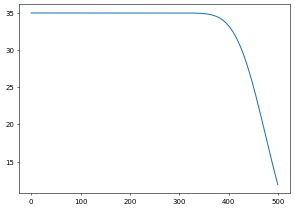

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

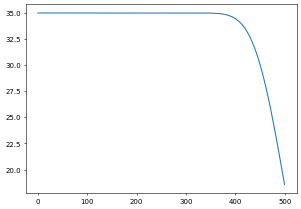

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

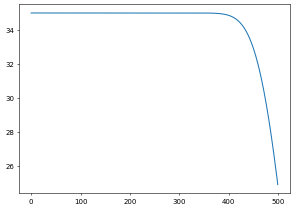

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

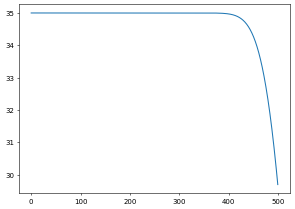

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

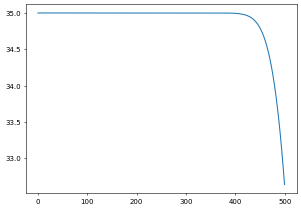

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

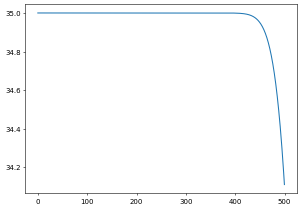

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

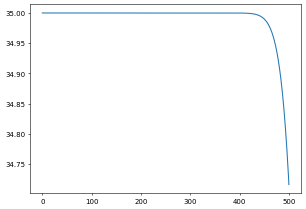

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

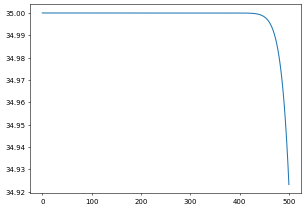

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

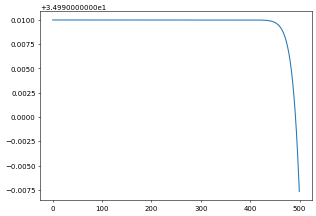

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

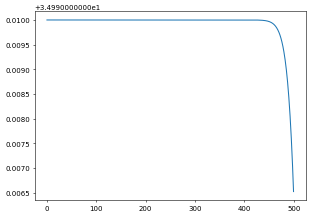

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

<Figure size 350x250 with 0 Axes>

In [ ]:

for i in range(nt):
    plt.figure(figsize=(7, 5), dpi=50)
    if i%5==0:
        plt.plot(x[0:1000], dummy_answer[i,0:1000])
#   plt.plot(x[0:1000], dummy_answer[5,0:1000])
#   plt.plot(x[0:1000], dummy_answer[10,0:1000])
# # dummy_answer
# for i in range (1,nt):
#     if temp_resposta[i] != 0:
#         plt.plot(x, dummy_answer[i,:])
        